# Module 2 Final Project - How Does Discount Impact Sales? 


### Northwind Database

<img src='Northwind_ERD.png'>

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab
%matplotlib inline
sns.set(style="ticks", color_codes=True)

from IPython.display import display, HTML

from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLSResults
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.formula.api as smf
import category_encoders as ce
from statsmodels.stats.power import TTestIndPower, FTestPower, FTestAnovaPower
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats.mstats import gmean

from patsy.contrasts import Sum
from patsy.contrasts import Helmert
from patsy.contrasts import Treatment
from patsy import dmatrices


In [2]:
# Functions 
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))
        
def z_hbar(data, y_col, x_col, xlabel, title):
    colors = sns.color_palette("GnBu_d", 10)
    plt.figure(figsize=(8,7))
    ax = sns.barplot(y = data[y_col], x = data[x_col], data=data, orient='h', palette=colors, errwidth=0.8,
           capsize=0.2)
    ax.set_xlabel(xlabel=xlabel, fontsize=14)
    ax.set_xticks(np.arange(-0.5, 1.5))
    ax.set_ylabel(ylabel='Participants', fontsize=14)
    ax.set_title(label=title, fontsize=17)
    plt.tight_layout();
    
def boxplot(data, x, y, xlabel, ylabel, title):
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
    fig, axes = plt.subplots(1, figsize=(14,6))
    sns.boxplot(x=x, y=y, data=data, ax=axes, palette=("husl"), boxprops=dict(alpha=.8), 
                showmeans=True, meanprops=meanpointprops)
    sns.swarmplot(x=x, y=y, data=data, color="grey", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14);
    
def stacked_bar(df, cat, groups, normalize=False, legend_label=[None], title=None, xlabel=None, ylabel=None):
    plt.style.use('seaborn-white')
    data = df.groupby(cat)[groups].value_counts(normalize=normalize).unstack(groups)
    
    data.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")
    
    ytick_labels = sorted(list(df[cat].unique()))
    legend_labels = legend_label
    
    plt.gca().invert_yaxis()
    plt.ylabel(ylabel)
    plt.yticks(np.arange(len(ytick_labels)), labels=ytick_labels, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.legend(legend_label, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=16);
    sns.despine(left=True, bottom=True);
    
# Test for power based on sample and expected effect size
def power(df_num, df_denom, alpha, effect):
    return FTestPower().solve_power(effect_size=effect, df_num=df_num, df_denom=df_denom, alpha=alpha)


In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
con = engine.connect()
metadata = MetaData()

In [4]:
product = pd.read_sql_query("""
SELECT o.EmployeeId, o.ShipRegion, od.Quantity, od.Discount, od.UnitPrice,
        c.Id as CategoryId, c.CategoryName, (p.UnitPrice * od.Quantity - o.Freight) as Revenue, 
        (p.UnitPrice * od.Quantity) as SalePrice, e.ReportsTo
       
FROM [Order] o
    join OrderDetail od
    on od.OrderID = o.ID
    
    JOIN Product p
    on od.ProductID = p.ID
    
    JOIN Category c 
    on c.ID = p.CategoryID  
    
    JOIN Employee e
    on o.EmployeeId = e.Id
    
    """, engine)              


In [5]:
product.head()

,EmployeeId,ShipRegion,Quantity,Discount,UnitPrice,CategoryId,CategoryName,Revenue,SalePrice,ReportsTo
0,5,Western Europe,12,0.0,14.0,4,Dairy Products,219.62,252.00,2.0
1,5,Western Europe,10,0.0,9.8,5,Grains/Cereals,107.62,140.00,2.0
2,5,Western Europe,5,0.0,34.8,4,Dairy Products,141.62,174.00,2.0
3,6,Western Europe,9,0.0,18.6,7,Produce,197.64,209.25,5.0
4,6,Western Europe,40,0.0,42.4,7,Produce,2108.39,2120.00,5.0


# Variables of Interest

## Discount

The figure below shows that Discount is primarily categorical. Therefore, it was binned into a Binary variable and into a more granulated Group variable (ordinal, with bins of 5%) for analysis. 

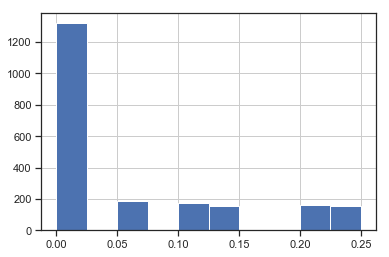

In [6]:
product.Discount.hist();

In [7]:
# Binary Discount 
product.loc[product['Discount'] == 0.0, 'DiscountBi'] = 0
product.loc[product['Discount'] > 0.0, 'DiscountBi'] = 1

# Binned Groups of 5%
product.loc[product['Discount'] == 0.0, 'DiscountGr'] = 0
product.loc[(product['Discount'] > 0.0) & (product['Discount'] <= 0.05), 'DiscountGr'] = 1
product.loc[(product['Discount'] > 0.05) & (product['Discount'] <= 0.10), 'DiscountGr'] = 2
product.loc[(product['Discount'] > 0.10) & (product['Discount'] <= 0.15), 'DiscountGr'] = 3
product.loc[(product['Discount'] > 0.15) & (product['Discount'] <= 0.20), 'DiscountGr'] = 4
product.loc[(product['Discount'] > 0.20) & (product['Discount'] <= 0.25), 'DiscountGr'] = 5

In [8]:
product.DiscountGr.isna().sum()

0

## Sales Price

To further evaluate whether:

i) Offering discounts benefits sales
ii) What level of discount best benefits sales

Sales Price was used as the outcome variable. Sales Price was feature engineered from **Unit Price * Quantity**, and therefore contains information about quantity as well as overall value of the sale. This may therefore be a more informative metric for decision making with regards to what discount to offer customers in the future. 

Since Sales is positively skewed, it may be [lognormally distributed](https://www.investopedia.com/terms/n/normaldistribution.asp).

# 1) Lognormal Distribution of Sales Prices

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


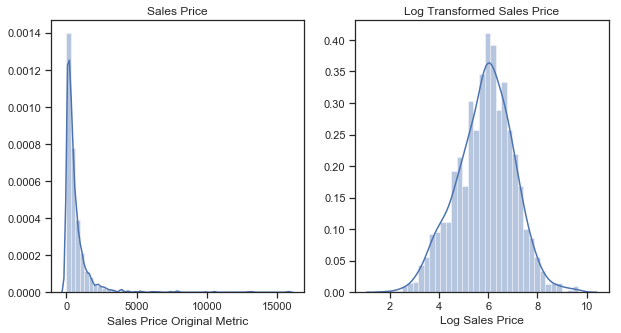

In [9]:
# The log transformed Sales Price indicates a relatively lognormal distribution 

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

sns.distplot(product.SalePrice, ax=ax1)
sns.distplot(np.log(product.SalePrice), ax=ax2);

ax1.set_title('Sales Price')
ax2.set_title('Log Transformed Sales Price')

#ax1.xaxis.label.set_visible(False)
ax1.xaxis.set_label_text('Sales Price Original Metric')
ax2.xaxis.set_label_text('Log Sales Price')

product['LogSales'] = np.log(product.SalePrice)

In [10]:
print('Log Sales\n', product.SalePrice.describe().round(2),end='\n\n')
print('Original Scale Sales\n', product.LogSales.describe().round(2))

Log Sales
 count     2155.00
mean       672.56
std       1110.26
min          6.00
25%        170.50
50%        380.00
75%        760.00
max      15810.00
Name: SalePrice, dtype: float64

Original Scale Sales
 count    2155.00
mean        5.86
std         1.16
min         1.79
25%         5.14
50%         5.94
75%         6.63
max         9.67
Name: LogSales, dtype: float64


In [11]:
# normality for log transformed Sales Price confirmed with Shapiro-Wilks
stats.shapiro(product.LogSales)

(0.9954862594604492, 4.2462002056709025e-06)

## Significance Testing and Log Sales

Sales Price was log transformed and the logarithmic mean was used for significance testing. If we convert the logarithmic mean back into our original scale, we create [geometric means](https://medium.com/@JLMC/understanding-three-simple-statistics-for-data-visualizations-2619dbb3677a), which are the anti-logs of the mean of the logged data. 

Furthermore, the coefficients must be interpreted as ratios rather than differences when converted back into the original metric. 

The exponentiated coefficient can be interpreted as the ratio of the expected geometric mean for one group compared with the expected geometric mean of the relative reference group(s). Marginal changes in the explanatory variables are interpreted in terms of multiplicative (percentage) changes in the dependent variable. 

In [12]:
group = product['DiscountGr'].unique()
group

array([0., 3., 1., 4., 5., 2.])

In [13]:
# Functions for converting the regression coefficients for interpretation 
def geo_mean_convert(B):
    # natural log of the input
    # exponentiation is inverse of logarithm 
    return round(np.exp(B), 2)

def geomean_ratio(coefficient, ref, group):
    # ratios of the natural logs for interpretation of the regression coefficients
    ratio = round(np.exp(coefficient), 2)
    print('The geometric mean of {} is {} times {}'.format(group.title(), ratio, ref.title()))
    if ratio > 1:
          print('The geometric mean of {} is {}% more than {}'.format(group.title(), 
                round(((ratio//1 - 1) + (ratio%1))*100,0), ref.title()))      
    else:
          print('The geometric mean of {} is {}% less than {}'.format(group.title(), 
                round((1 - ratio%1)*100, 2), ref.title()))
      
def ci_geometric_ratio(lower, upper):
    low = geo_mean_convert(lower) 
    high = geo_mean_convert(upper)
    print('The ratio is between {} and {}'.format(low, high)) 
                
def geo_means(data, x, y):
    # Summary statistics including geometric means for comparison
    groups = sorted(list(data[x].unique()))
    geo_mean = [round(gmean(data.loc[data[x] == group][y]), 2) for group in groups]
    median = [round((data.loc[data[x] == group][y].median()), 2) for group in groups] 
    amean = [round(data.loc[data[x] == group][y].mean(), 2) for group in groups]
    std = [round(data.loc[data[x] == group][y].std(), 2) for group in groups]
    df = pd.DataFrame({x:groups, 'geo_mean': geo_mean, 'median': median, 'mean': amean, 'std_dev': std})
    return df

gmean(product.loc[product['DiscountBi'] == 0.0]['SalePrice'])
product.groupby('DiscountBi').median()

,EmployeeId,Quantity,Discount,UnitPrice,CategoryId,Revenue,SalePrice,ReportsTo,DiscountGr,LogSales
DiscountBi,,,,,,,,,,
0.0,4,18,0.00,18.4,4,276.84,357.5,2.0,0.0,5.879135
1.0,4,20,0.15,18.0,4,367.58,440.8,2.0,3.0,6.088590


## Discount and Sales

A series of OLS models using _LogSales_ were run; the models were not complete since the aim was not overall predictive accuracy, but rather establishing relationships (or lack thereof) between variables. Since the F-test of the OLS model is identical to ANOVA, OLS was preferred for it's enhanced flexibility (ability to combine categorical and continuous variables), improved robustness, and better diagnostic/influence tests. 

The _F-test_ evaluates the significance of $R_2$ compared to the null (nil) hypothesis, (i.e., that $R_2$ is 0). $R_2$ also doubles as an effect size. 
 

**Hypotheses:**

$H_0$: **Discount does not significantly impact Sales Price**

$H_1$: **Discount does significantly impact Sales Price**


In [14]:
# Dummy contrast matrix for OLS group comparisons 

levels = [i for i in range(0, len(set(product.DiscountGr)))]
levels1 = [i for i in range(2)]

# Discount = None (index 0) is set as the reference group; all levels of discount will be compared to no discount
dummy_con = Treatment(reference=0).code_without_intercept(levels)
dummy_bi = Treatment(reference=0).code_without_intercept(levels1)

print(dummy_con.matrix)

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [15]:
# No Discount vs Discount regressed on Log Sales
lm = smf.ols('LogSales ~ C(DiscountBi)', data = product).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     22.44
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           2.31e-06
Time:                        13:54:04   Log-Likelihood:                -3375.0
No. Observations:                2155   AIC:                             6754.
Df Residuals:                    2153   BIC:                             6765.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.7652 

In [16]:
# The geometric mean is not identical to the median because the data is not perfectly lognormal 
geo_means(product, 'DiscountBi', 'SalePrice')

,DiscountBi,geo_mean,median,mean,std_dev
0,0.0,319.01,357.5,606.96,1009.23
1,1.0,406.96,440.8,775.66,1246.37


In [17]:
# The anti-log for the sum of the intercept and coefficient is the geomean for the Discount group (as confirmed above) 
print('Geometric mean Sales Price for Discount:', geo_mean_convert((0.2435 + 5.7652)))

# The intercept gives the geometric mean for the No Discount Group
print('Geometric mean Sales Price for No Discount:', geo_mean_convert(5.7652))

# Using only the coefficient gives the ratio between geometric means
print('Ratio between geometric mean values:', geo_mean_convert(0.2435))

Geometric mean Sales Price for Discount: 406.95
Geometric mean Sales Price for No Discount: 319.0
Ratio between geometric mean values: 1.28


In [18]:
# The ratio between geometric means is further explored:
geomean_ratio(0.2435, 'no discount', 'discount')
ci_geometric_ratio(0.143, 0.344)

The geometric mean of Discount is 1.28 times No Discount
The geometric mean of Discount is 28.0% more than No Discount
The ratio is between 1.15 and 1.41


## INTERPRETATION


Interpreting the main effect of discount, the intercept $B_0$ is the mean _Log Sales Price_ for the _no discount_ (reference) category. The coefficient for Discount indicates the ratio between the geometric mean of the discount and no discount group. To clarify, the ratio of geometric means is 1.28:1 for discount : no discount, or the geometric mean of Sales for discount (_GM_ = 406.95) is 28% higher than no discount (_GM_ = 319.0). 

Discount significantly increased sales compared with no discount. Therefore, we fail to reject the null and accept that offering a discount did increase Sales. 

**Follow Up Hypotheses:**

$H_0$: **All levels of discount are equal with regards to Sales Price**

$H_1$: **Levels of discount differ with regards to Sales Price**

In [19]:
# Contrast only discount categories

discount = product.loc[product['DiscountGr'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGr)))]

# Sum contrast for discount - each group is compared to the unweighted mean of all other groups
sum_dd = Sum(omit=0).code_without_intercept(levels)

print(sum_dd.matrix)

[[-1. -1. -1. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [20]:
# Each discount group is compared to the no discount group
# The intercept represents the log mean Sales for the no discount group
lm = smf.ols('LogSales ~ C(DiscountGr)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.149
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           0.000106
Time:                        13:54:04   Log-Likelihood:                -3373.4
No. Observations:                2155   AIC:                             6759.
Df Residuals:                    2149   BIC:                             6793.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.7652 

In [21]:
geo_means(product, 'DiscountGr', 'SalePrice')

,DiscountGr,geo_mean,median,mean,std_dev
0,0.0,319.01,357.5,606.96,1009.23
1,1.0,409.82,426.0,856.43,1533.78
2,2.0,365.63,397.5,640.90,704.16
3,3.0,413.40,450.0,702.65,743.85
4,4.0,398.80,397.5,767.93,1503.98
5,5.0,457.67,482.5,909.75,1420.79


In [22]:
# Each discount group is compared to the unweighted mean of all other groups
# The intercept represents the unweighted log mean Sales for all discount groups
lm = smf.ols('LogSales ~ C(DiscountGr, sum_dd)', data = discount).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7741
Date:                Mon, 14 Jan 2019   Prob (F-statistic):              0.542
Time:                        13:54:04   Log-Likelihood:                -1317.6
No. Observations:                 838   AIC:                             2645.
Df Residuals:                     833   BIC:                             2669.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## MODEL DIAGNOSTICS

Residuals are normally distributed
Shapiro Wilks (Normality Test):  (0.993193507194519, 0.0007205959991551936)
Het Goldfeldquant (Heteroscedasticity):  [('F statistic', 1.05432023059673), ('p-value', 0.2953633247391936)]


C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


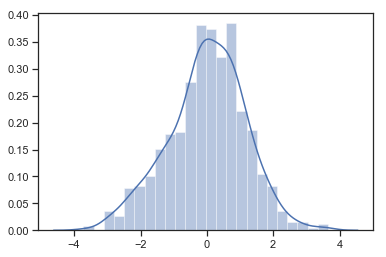

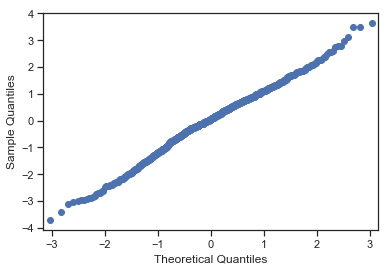

In [23]:
def diagnostics(lm):
    residuals = lm.resid
    sns.distplot(residuals)
    shapiro = stats.shapiro(residuals)
    if shapiro[1] < 0.05:
        print('Residuals are normally distributed')
    else:
        print('Residuals are not normally distributed')
    print('Shapiro Wilks (Normality Test): ', shapiro)
    sm.qqplot(lm.resid)
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
    print('Het Goldfeldquant (Heteroscedasticity): ', list(zip(name, test)))
diagnostics(lm)

In [24]:
infl = lm.get_influence()
sm_fr = infl.summary_frame()

sm_fr['fitted'] = lm.fittedvalues

sm_fr.nlargest(10, 'standard_resid')


,dfb_Intercept,"dfb_C(DiscountGr, sum_dd)[S.1]","dfb_C(DiscountGr, sum_dd)[S.2]","dfb_C(DiscountGr, sum_dd)[S.3]","dfb_C(DiscountGr, sum_dd)[S.4]",cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits,fitted
1620,0.094882,-0.048227,-0.046399,-0.046844,-0.046059,0.010271,3.131941,0.005208,0.226619,3.148654,0.227829,6.015717
281,0.108404,-0.055099,-0.053012,0.214081,-0.052623,0.011254,3.000489,0.006211,0.237210,3.015025,0.238359,5.988468
471,0.107771,-0.054778,-0.052702,0.212831,-0.052316,0.011124,2.983158,0.006211,0.235839,2.997421,0.236967,5.988468
331,0.101560,-0.051621,-0.049665,-0.050141,0.197204,0.009468,2.691324,0.006494,0.217581,2.701479,0.218402,6.126157
1483,0.076720,-0.038995,-0.037518,-0.037878,-0.037243,0.006743,2.537612,0.005208,0.183615,2.545948,0.184218,6.015717
1727,0.090144,-0.045819,-0.044083,-0.044505,0.175038,0.007473,2.391026,0.006494,0.193303,2.397833,0.193853,6.126157
2019,0.090144,-0.045819,-0.044083,-0.044505,0.175038,0.007473,2.391026,0.006494,0.193303,2.397833,0.193853,6.126157
1391,0.071043,-0.036110,-0.034742,-0.035075,-0.034487,0.005788,2.351148,0.005208,0.170123,2.357571,0.170588,6.015717
1924,0.084210,-0.042802,-0.041181,-0.041575,0.163515,0.006527,2.234596,0.006494,0.180656,2.239978,0.181091,6.126157
218,0.066143,-0.033619,-0.032346,-0.032656,-0.032109,0.005022,2.189951,0.005208,0.158459,2.194964,0.158822,6.015717


## FINAL INTERPRETATION OF LEVELS OF DISCOUNT ON SALES

A sum contrast was used to compare each level of discount with all other levels (i.e., the geometric mean for each level of discount was compared with the combined geometric mean for all other levels). Significance testing indicated that level of discount accounted for no variance/ effect in LogSales, _F = 0.6577, p = 0.54_. Therefore, individual contrasts will not be investigated further and we can conclude that, while some discount is significantly related to Sales, the level of discount is inconsequential. We therefore fail to reject the null, and accept that all levels of discount are equal with regards to Sales. 


## CONCLUSION

The above two analyses indicated that, on average, Sales Price was 28% higher when a discount was offered. While almost all discount groups differed significantly from no discount, the amount of discount offered did not significantly impact Sales Price. Therefore, based on these analyses we can consider offering a discount of 1 - 5%. 

Discounts > 5% = 87 448.93 Euros, or 6.03% of total sales. This could potentially be saved if smaller discounts are as effective as larger ones in increasing the number of items ordered/ overall price of the sale. 


In [25]:
# to calculate savings figures above

#savings = product.loc[product['DiscountGrouped'] > 1]
#discounts = savings.Discount * savings.SalePrice
#(discounts.sum()/ product.SalePrice.sum()) * 100

## FOLLOW UP ANALYSES:

Before any final recommendations with regards to discount can be made, it is necessary to understand how discount may affect Sales Price for various Categories of product and Regions of Sale. 



# CATEGORY

There are 8 categories of product. It is possible that between- and within-category effects differ from the overall effects seen in the previous analysis.  

In particular, it is important whether any interactions between category and discount exist (i.e., partialed effects - contribution to $R_2$ over and above the main effects of discount and category on Sales).

In this instance _Category_ is a fixed effect as it represents all categories of product available for this company and our conclusions apply only to these conditions of discount and category. Therefore, the interactions test the hypotheses:

$H_0$: **Levels of discount uniformly affect Sales for all categories of product**

$H_1$: **Levels of discount do not uniformly affect Sales for all categories of product**

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales

Should we find that sales within certain categories are more or less affected by discount, and specific levels of discount, this will allow a more nuanced approach to discount. 

In [26]:
# Descriptives for each level of Discount and Category
print(product.groupby(['CategoryName', 'DiscountBi'])['SalePrice'].agg(['mean','std', 'median', min, max]).round(2))

                              mean      std  median    min      max
CategoryName   DiscountBi                                          
Beverages      0.0          661.52  1750.66  252.00  13.50  15810.0
               1.0          929.42  2218.29  360.00  27.00  15810.0
Condiments     0.0          492.00   470.18  400.00  17.00   2853.5
               1.0          681.07   695.03  427.50  25.00   3512.0
Confections    0.0          577.52   700.30  358.75   9.20   5268.0
               1.0          558.39   642.88  390.00  34.90   4050.0
Dairy Products 0.0          651.53   741.67  425.00  12.50   6050.0
               1.0          867.51   848.40  691.75  10.00   5500.0
Grains/Cereals 0.0          529.38   596.61  360.00  14.00   4322.5
               1.0          578.42   500.99  456.00  28.00   2280.0
Meat/Poultry   0.0          973.10  1431.70  480.00  22.35   9903.2
               1.0         1267.00  1532.59  720.00  22.35   7427.4
Produce        0.0          736.03   597.29  540

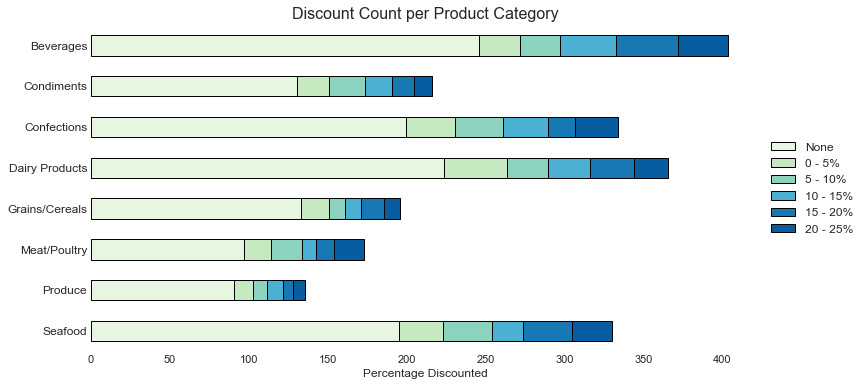

In [27]:
stacked_bar(product, 'CategoryName', 'DiscountGr', 
            title='Discount Count per Product Category',
            legend_label=['None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'],
            xlabel='Percentage Discounted') 
            

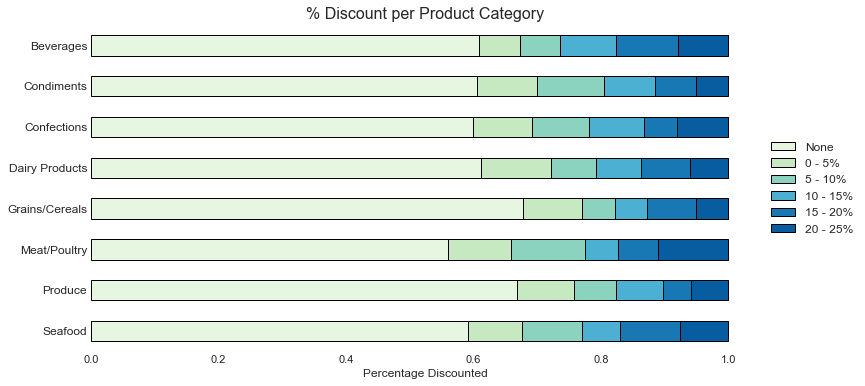

In [28]:
stacked_bar(product, 'CategoryName', 'DiscountGr',
            normalize=True,
            title='% Discount per Product Category',
            legend_label=['None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'],
            xlabel='Percentage Discounted')

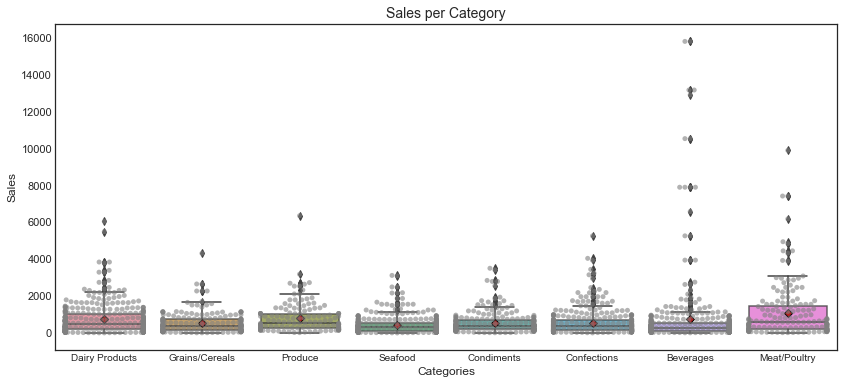

In [29]:
boxplot(product, 'CategoryName', 'SalePrice', 'Categories', 'Sales', 'Sales per Category')

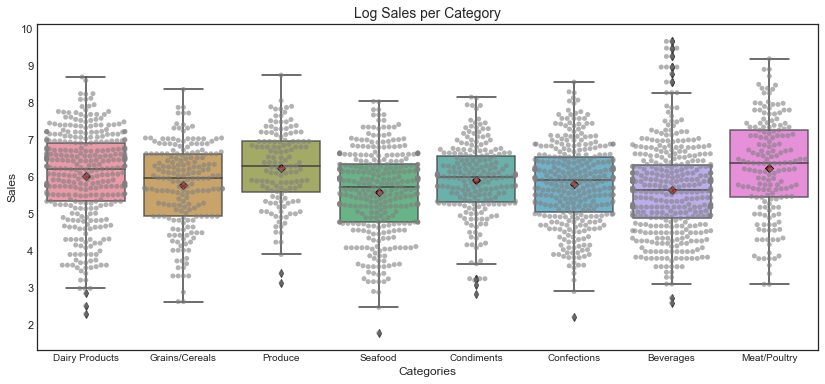

In [30]:
# Log Sales appeared to normalize distributions for each category as well
boxplot(product, 'CategoryName', 'LogSales', 'Categories', 'Sales', 'Log Sales per Category')

In [31]:
# create a separate df for each category
list_cat_df = []
for i in product.CategoryId.unique():
    locals()['cat' + str(i) + '_df'] = product.loc[product['CategoryId'] == i].reset_index()

In [32]:
levels = [i for i in range(len(set(product.CategoryId)))]
levels1 = [i for i in range(len(set(product.DiscountGr)))]

sum_c = Sum(omit=0).code_without_intercept(levels)
dummy_c = Treatment(reference=0).code_without_intercept(levels)
sum_d = Sum(omit=5).code_without_intercept(levels1)

#print('Sum Contrast Matrix - Categories\n', sum_c.matrix, end='\n\n')
#print('Dummy Contrast Matrix - Categories\n', dummy_c.matrix, end='\n\n')
#print('Sum Contrast Matrix - Discount\n', sum_d.matrix)

In [33]:
# Category sample sizes
product.groupby(['CategoryId'])['CategoryName'].value_counts()

CategoryId  CategoryName  
1           Beverages         404
2           Condiments        216
3           Confections       334
4           Dairy Products    366
5           Grains/Cereals    196
6           Meat/Poultry      173
7           Produce           136
8           Seafood           330
Name: CategoryName, dtype: int64

## 

In [34]:
list_cat_df = [cat1_df, cat2_df, cat3_df, cat4_df, cat5_df, cat6_df, cat7_df, cat8_df]
list_cat_further_analysis = [cat1_df, cat2_df, cat4_df, cat8_df]

def category_discount(list_df, alpha=0.05, power=0.8, effect=0.25):
    for ind, i in enumerate(list_df, start=1):
        lm = smf.ols('LogSales ~ C(DiscountGr, sum_d)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i.CategoryName.unique(), 'CategoryID: ' + str(ind))
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,1:])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))

category_discount(list_cat_further_analysis)

['Beverages'] CategoryID: 1
------------------------------------------------------------------------------
<F test: F=array([[1.74896381]]), p=0.12241258366825412, df_denom=398, df_num=5>
R2 Adjusted:  0.016972515470041527
         coef    std err          z   P>|z|     [0.025     0.975]
0      5.8236      0.088     66.068   0.000      5.651      5.996
1     -0.2861      0.108     -2.643   0.008     -0.498     -0.074
Power for given sample size for an effect of 0.25: 0.9988902347255294


['Condiments'] CategoryID: 2
------------------------------------------------------------------------------
<F test: F=array([[1.06774611]]), p=0.3792903506599057, df_denom=210, df_num=5>
R2 Adjusted:  0.007215369391063486
         coef    std err          z   P>|z|     [0.025     0.975]
0      6.0624      0.104     58.405   0.000      5.859      6.266
1     -0.2533      0.124     -2.044   0.041     -0.496     -0.010
Power for given sample size for an effect of 0.25: 0.9560209364058609


['Dairy Produc

In [35]:
category_discount(list_cat_df)

['Beverages'] CategoryID: 1
------------------------------------------------------------------------------
<F test: F=array([[1.74896381]]), p=0.12241258366825412, df_denom=398, df_num=5>
R2 Adjusted:  0.016972515470041527
         coef    std err          z   P>|z|     [0.025     0.975]
0      5.8236      0.088     66.068   0.000      5.651      5.996
1     -0.2861      0.108     -2.643   0.008     -0.498     -0.074
Power for given sample size for an effect of 0.25: 0.9988902347255294


['Condiments'] CategoryID: 2
------------------------------------------------------------------------------
<F test: F=array([[1.06774611]]), p=0.3792903506599057, df_denom=210, df_num=5>
R2 Adjusted:  0.007215369391063486
         coef    std err          z   P>|z|     [0.025     0.975]
0      6.0624      0.104     58.405   0.000      5.859      6.266
1     -0.2533      0.124     -2.044   0.041     -0.496     -0.010
Power for given sample size for an effect of 0.25: 0.9560209364058609


['Confections'

## COMPARISON OF ALL LEVELS OF DISCOUNT 

Each discount level was compared with the unweighted sum of all other discount levels for each Category. For the following Categories, No Discount was significantly lower:

- Beverages
- Condiments
- Dairy Products
- Seafood

For Seafood, discounts of 15 - 20% were significantly higher than all other levels of discount. 




In [36]:
print('Beverages', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.2861,'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.498, -0.074)
print('\n')

print('Condiments', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.2533, 'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.496, -0.010)
print('\n')

print('Dairy Products', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.2736, 'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.492, -0.055)
print('\n')

print('Seafood', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.2550, 'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.457, -0.053)
print('\n')
geomean_ratio(0.3814, 'all other levels of discount', '15 - 20% Discount')
ci_geometric_ratio(0.032, 0.730)

Beverages
----------------------------------------------------------------
The geometric mean of No Discount is 0.75 times All Other Levels Of Discount
The geometric mean of No Discount is 25.0% less than All Other Levels Of Discount
The ratio is between 0.61 and 0.93


Condiments
----------------------------------------------------------------
The geometric mean of No Discount is 0.78 times All Other Levels Of Discount
The geometric mean of No Discount is 22.0% less than All Other Levels Of Discount
The ratio is between 0.61 and 0.99


Dairy Products
----------------------------------------------------------------
The geometric mean of No Discount is 0.76 times All Other Levels Of Discount
The geometric mean of No Discount is 24.0% less than All Other Levels Of Discount
The ratio is between 0.61 and 0.95


Seafood
----------------------------------------------------------------
The geometric mean of No Discount is 0.77 times All Other Levels Of Discount
The geometric mean of No Discou

In [37]:
# For those categories where Sales for No Discount were significantly less, 
# further investigation was carried out to determine whether any specific discounts 
# were responsible for the differences. 


def category_discount(list_df, alpha=0.05, power=0.8, effect=0.25):
    for ind, i in enumerate(list_df, start=1):
        lm = smf.ols('LogSales ~ C(DiscountGr)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i.CategoryName.unique(), 'CategoryID: ' + str(ind))
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,1:])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))

category_discount(list_cat_further_analysis)

['Beverages'] CategoryID: 1
------------------------------------------------------------------------------
<F test: F=array([[1.74896381]]), p=0.12241258366825836, df_denom=398, df_num=5>
R2 Adjusted:  0.016972515470041194
         coef    std err          z   P>|z|     [0.025     0.975]
0      5.5375      0.077     71.941   0.000      5.387      5.688
1      0.7753      0.330      2.346   0.019      0.128      1.423
Power for given sample size for an effect of 0.25: 0.9988902347255294


['Condiments'] CategoryID: 2
------------------------------------------------------------------------------
<F test: F=array([[1.06774611]]), p=0.3792903506598947, df_denom=210, df_num=5>
R2 Adjusted:  0.007215369391063486
         coef    std err          z   P>|z|     [0.025     0.975]
0      5.8091      0.083     70.134   0.000      5.647      5.971
Power for given sample size for an effect of 0.25: 0.9560209364058609


['Dairy Products'] CategoryID: 3
-----------------------------------------------

## INTERPRETATION

Three Product Categories showed specific discounts to be responsible for increased sales:

- Beverages
- Dairy Products
- Seafood

While for Condiments, the level of discount did not seem to matter.

Further descriptives for these categories are given below.


In [38]:

for i in list_cat_further_analysis:
    print(i.CategoryName.unique())
    print(geo_means(i, 'DiscountGr', 'SalePrice'))
    print('\n\n')

['Beverages']
   DiscountGr  geo_mean  median     mean  std_dev
0         0.0    254.04  252.00   661.52  1750.66
1         1.0    551.59  438.75  1872.04  3478.37
2         2.0    345.09  360.00   613.27   851.77
3         3.0    295.17  360.00   455.35   381.47
4         4.0    365.38  325.50  1102.97  2841.22
5         5.0    286.79  360.00   732.34  1837.94



['Condiments']
   DiscountGr  geo_mean  median     mean  std_dev
0         0.0    333.33  400.00   492.00   470.18
1         1.0    450.38  421.02   668.10   536.12
2         2.0    348.35  396.00   471.93   367.88
3         3.0    441.89  364.00   830.15   970.64
4         4.0    426.42  433.75   585.35   406.56
5         5.0    636.17  550.00  1033.37  1097.04



['Dairy Products']
   DiscountGr  geo_mean  median     mean  std_dev
0         0.0    369.86  425.00   651.53   741.67
1         1.0    456.66  537.50   782.05   743.08
2         2.0    443.44  664.00   709.37   578.35
3         3.0    541.16  792.00  1005.63   929

In [39]:
print('Beverages', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.7753, 'No Discount', '1 - 5% Discount')
ci_geometric_ratio(0.128, 1.423)
print('\n')

print('Dairy Products', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.5403, 'No Discount', '20 - 25% Discount')
ci_geometric_ratio(0.003, 1.077)
print('\n')

print('Seafood', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.4830, 'No Discount', '10 - 15% Discount')
ci_geometric_ratio(0.041, 0.925)
print('\n')
geomean_ratio(0.6365, 'No Discount', '15 - 20% Discount')
ci_geometric_ratio(0.223, 1.050)

Beverages
----------------------------------------------------------------
The geometric mean of 1 - 5% Discount is 2.17 times No Discount
The geometric mean of 1 - 5% Discount is 117.0% more than No Discount
The ratio is between 1.14 and 4.15


Dairy Products
----------------------------------------------------------------
The geometric mean of 20 - 25% Discount is 1.72 times No Discount
The geometric mean of 20 - 25% Discount is 72.0% more than No Discount
The ratio is between 1.0 and 2.94


Seafood
----------------------------------------------------------------
The geometric mean of 10 - 15% Discount is 1.62 times No Discount
The geometric mean of 10 - 15% Discount is 62.0% more than No Discount
The ratio is between 1.04 and 2.52


The geometric mean of 15 - 20% Discount is 1.89 times No Discount
The geometric mean of 15 - 20% Discount is 89.0% more than No Discount
The ratio is between 1.25 and 2.86


In [40]:
no_results_cat = [cat3_df, cat5_df, cat6_df, cat7_df]
total_discounts = 0
total_sales = 0
discounted_sales = 0
for cat in no_results_cat:
    df = cat.loc[cat['DiscountBi'] == 1].copy()
    df['DiscountValue'] = df.SalePrice * df.Discount
    discount = sum(df.DiscountValue)
    print('Total Discount on Sales for {} was {} Euros'.format(cat.CategoryName.unique(), round(discount, 2)))
    total_discounts += discount
    discounted_sales += sum(df.SalePrice)
    total_sales += sum(cat.SalePrice)

print('\nTotal discount offered for these Product Categories was {} Euros.'. format(round(total_discounts,2)))
print('This was {}% of discounted sales.'. format(round((total_discounts/discounted_sales)*100,2)))
print('This was {}% of all sales.'. format(round((total_discounts/total_sales)*100,2)))

Total Discount on Sales for ['Confections'] was 10464.89 Euros
Total Discount on Sales for ['Grains/Cereals'] was 5201.06 Euros
Total Discount on Sales for ['Meat/Poultry'] was 16060.14 Euros
Total Discount on Sales for ['Produce'] was 5649.3 Euros

Total discount offered for these Product Categories was 37375.38 Euros.
This was 14.83% of discounted sales.
This was 6.24% of all sales.


In [41]:
for i in list_cat_further_analysis:
    print(i.CategoryName.unique())
    print(geo_means(i, 'DiscountBi', 'SalePrice'))
    print('\n\n')

['Beverages']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    254.04   252.0  661.52  1750.66
1         1.0    351.43   360.0  929.42  2218.29



['Condiments']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    333.33   400.0  492.00   470.18
1         1.0    433.75   427.5  681.07   695.03



['Dairy Products']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    369.86  425.00  651.53   741.67
1         1.0    504.69  691.75  867.51   848.40



['Seafood']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    238.09   265.0  404.88   444.25
1         1.0    321.89   380.0  519.32   521.94





## FINAL INTERPRETATION - DISCOUNT x CATEGORY

The _lack_ of support for discount significantly impacting sales for half of the product categories is surprising and informative. Considering this, it appears that offering discounts is failing to drive sales for **Confections, Grains/Cereals, Meat/Poultry, and Produce**. Nevertheless, an average of 15% in discounts (37 375 Euros) were still offered for these products.

Certain levels of discount did appear to drive sales for Beverages, Dairy Products and Seafood. In particular:

- For **Beverages** discounts between 1 - 5% significantly increased Sales from 254.04 to 551.59 Euro -  117% increase (with a [range](http://www.jerrydallal.com/lhsp/ci_logs.htm) from 14% - 315%). Sales where no discount was offered (GM = 254.04) were 25% less than for combineded discount sales (GM = 351.43; range: 7% - 39%). 


- For **Dairy Products** discounts between 20 - 25% significantly increased Sales from 369.86 to 634.90 Euro - 72% increase (with a range from 0 - 194%) -- since the lower range here is 0%, and the sample is well powered, it is perhaps too variable to be relied upon. Sales where no discount was offered (GM = 369.86) were 24% less than for combined discount sales (GM = 504.69; range: 5% - 39%).


- For **Seafood** discounts between 10 - 15% significantly increased Sales from 238.09 to 385.93 Euros - 62% increase (range: 4% - 152%). A lower range of 4% is also very close to zero, and should be relied on with caution. Discounts between 20 - 25% significantly increased Sales to 449.93 - 89% (range:25% - 186%). Sales where no discount was offered (GM = 238.09) were 23% less than for combined discount sales (GM = 321.89; range: 5% - 37%). 


- For **Condiments** sales where no discount was offered (GM = 369.86) were 22% less than for combined discount sales (GM = 321.89; range: 5% - 39%). Although No Discount led to significantly less sales, the size of the discount offered did not appear to make a difference. Therefore, a 1- 5% discount is likely as effective as any other discount for the product category (7683 Euros in discounts above 5% were given). 

Considering this, discount should be considered on a category by category basis, since it only appears to be significantly impacting 4 Product Categories.


In [42]:
cat2_discount = cat2_df.loc[cat2_df['DiscountGr'] > 1]
dis = sum(cat2_discount.SalePrice * cat2_discount.Discount)
dis/sum(cat2_discount.SalePrice)*100

17.25409592165115

## MODEL DIAGNOSTICS



# Region

There are 9 Shipping Regions. It is possible that the effect of discount may also differ by Region (discount x region interaction).  

In this instance _ShipRegion_ is a fixed effect as it represents all regions available for this company and our conclusions apply only to these conditions of discount and region. Therefore, the interactions test the hypotheses:

$H_0$: **Discount uniformly affects Regions for all categories of product**

$H_1$: **Discount does not uniformly affect Regions for all categories of product**

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales

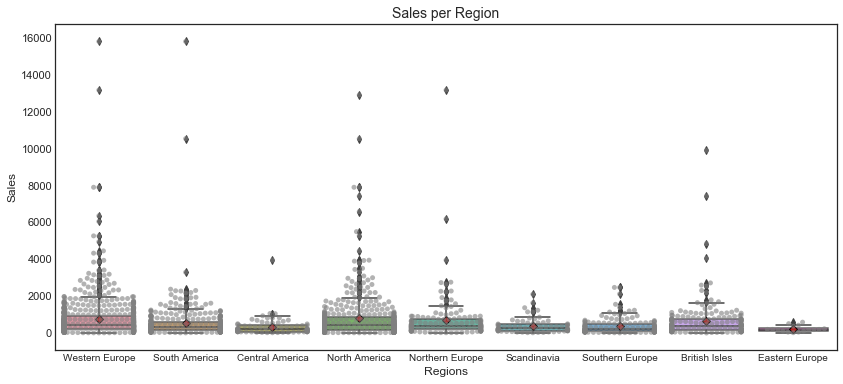

In [43]:
boxplot(product, 'ShipRegion', 'SalePrice', 'Regions', 'Sales', 'Sales per Region')

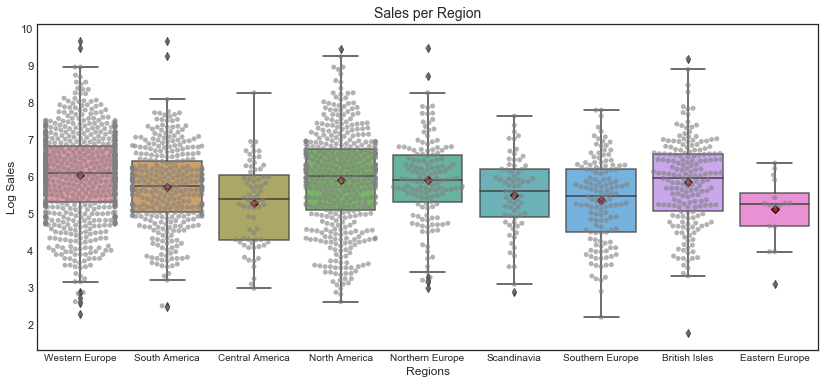

In [44]:
boxplot(product, 'ShipRegion', 'LogSales', 'Regions', 'Log Sales', 'Sales per Region')

In [45]:
# create a separate df for each shipping region
for i in product.ShipRegion.unique():
    locals()[str(i).replace(' ', '_')] = product.loc[product['ShipRegion'] == i]


In [46]:
# Eastern Europe had no discounted sales 
list_ship_df = [Western_Europe, South_America, North_America, 
                Northern_Europe, Southern_Europe, British_Isles]
list_smaller_regions = [Central_America, Scandinavia]

In [47]:
# Each level of discount vs all others

def region_discount(list_df, alpha=0.05, power=0.8, effect=0.25):
    for i in list_df:
        lm = smf.ols('LogSales ~ C(DiscountGr, sum_d)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i.ShipRegion.unique())
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,1:7])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))
    
    # calculate required sample size for specified power and alpha values 
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect, 
                                         power = power, 
                                         alpha = alpha)
    print('Required sample size for power {} and effect size {}: {}'.format(power, effect, round(sample_size)))

In [48]:
region_discount(list_ship_df, effect=0.2)

['Western Europe']
------------------------------------------------------------------------------
<F test: F=array([[0.32570786]]), p=0.8975921926835551, df_denom=739, df_num=5>
R2 Adjusted:  -0.0043911437763146655
         coef    std err          z   P>|z|     [0.025     0.975]
0      6.0790      0.054    111.753   0.000      5.972      6.186
Power for given sample size for an effect of 0.2: 0.9997634777296478


['South America']
------------------------------------------------------------------------------
<F test: F=array([[0.13544863]]), p=0.9840753444856514, df_denom=349, df_num=5>
R2 Adjusted:  -0.012760469136179342
         coef    std err          z   P>|z|     [0.025     0.975]
0      5.7491      0.082     70.351   0.000      5.589      5.909
Power for given sample size for an effect of 0.2: 0.9643352246482493


['North America']
------------------------------------------------------------------------------
<F test: F=array([[3.51526248]]), p=0.003997635801616138, df_denom=42

In [49]:
print('North America', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.3048,'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.514, -0.096)
print('\n')
geomean_ratio(0.3836, 'all other levels of discount', '10 - 15% Discount')
ci_geometric_ratio(0.012, 0.755)
print('\n')

print('Southern Europe', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.5134, 'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.843, -0.184)
print('\n')

print('British Isles', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(-0.5706, 'all other levels of discount', 'No Discount')
ci_geometric_ratio(-0.873, -0.269)


North America
----------------------------------------------------------------
The geometric mean of No Discount is 0.74 times All Other Levels Of Discount
The geometric mean of No Discount is 26.0% less than All Other Levels Of Discount
The ratio is between 0.6 and 0.91


The geometric mean of 10 - 15% Discount is 1.47 times All Other Levels Of Discount
The geometric mean of 10 - 15% Discount is 47.0% more than All Other Levels Of Discount
The ratio is between 1.01 and 2.13


Southern Europe
----------------------------------------------------------------
The geometric mean of No Discount is 0.6 times All Other Levels Of Discount
The geometric mean of No Discount is 40.0% less than All Other Levels Of Discount
The ratio is between 0.43 and 0.83


British Isles
----------------------------------------------------------------
The geometric mean of No Discount is 0.57 times All Other Levels Of Discount
The geometric mean of No Discount is 43.0% less than All Other Levels Of Discount
The 

In [50]:
list_region_further_analysis = [North_America, Southern_Europe, British_Isles]

for i in list_region_further_analysis:
    print(i.ShipRegion.unique())
    print(geo_means(i, 'DiscountBi', 'SalePrice'))
    print('\n\n')

['North America']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    326.33   385.7  700.52  1132.62
1         1.0    456.84   523.5  952.06  1489.09



['Southern Europe']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    175.17   190.0  328.24   424.74
1         1.0    287.71   328.0  446.44   436.40



['British Isles']
   DiscountBi  geo_mean  median    mean  std_dev
0         0.0    284.44   300.0  525.03   939.29
1         1.0    545.72   628.2  943.18  1235.28





In [51]:
no_results_region = [Western_Europe, South_America, Northern_Europe]
total_discounts = 0
total_sales = 0
discounted_sales = 0
for region in no_results_region:
    df = region.loc[region['DiscountBi'] == 1].copy()
    df['DiscountValue'] = df.SalePrice * df.Discount
    discount = sum(df.DiscountValue)
    print('Total Discount on Sales for {} was {} Euros'.format(cat.CategoryName.unique(), round(discount, 2)))
    total_discounts += discount
    discounted_sales += sum(df.SalePrice)
    total_sales += sum(region.SalePrice)

print('\nTotal discount offered for these Product Categories was {} Euros.'. format(round(total_discounts,2)))
print('This was {}% of discounted sales.'. format(round((total_discounts/discounted_sales)*100,2)))
print('This was {}% of all sales.'. format(round((total_discounts/total_sales)*100,2)))

Total Discount on Sales for ['Produce'] was 34909.24 Euros
Total Discount on Sales for ['Produce'] was 13449.17 Euros
Total Discount on Sales for ['Produce'] was 7383.6 Euros

Total discount offered for these Product Categories was 55742.01 Euros.
This was 14.29% of discounted sales.
This was 6.39% of all sales.


In [52]:
# Each level of discount vs No Discount for significant Regions


def region_discount(list_df, alpha=0.05, power=0.8, effect=0.25):
    for i in list_df:
        lm = smf.ols('LogSales ~ C(DiscountGr)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i.ShipRegion.unique())
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,:5])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))
    
    # calculate required sample size for specified power and alpha values 
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect, 
                                         power = power, 
                                         alpha = alpha)
    print('Required sample size for power {} and effect size {}: {}'.format(power, effect, round(sample_size)))

In [53]:
region_discount(list_region_further_analysis)

['North America']
------------------------------------------------------------------------------
<F test: F=array([[3.51526248]]), p=0.003997635801616486, df_denom=421, df_num=5>
R2 Adjusted:  0.019453396132920298
                    OLS        coef    std err          z   P>|z|
0             Intercept      5.7879      0.081     71.235   0.000
1  C(DiscountGr)[T.3.0]      0.6883      0.224      3.076   0.002
2  C(DiscountGr)[T.5.0]      0.6232      0.199      3.127   0.002
Power for given sample size for an effect of 0.25: 0.9993137805679764


['Southern Europe']
------------------------------------------------------------------------------
<F test: F=array([[2.86773336]]), p=0.017203441653012023, df_denom=131, df_num=5>
R2 Adjusted:  0.05315490823285829
                    OLS        coef    std err          z   P>|z|
0             Intercept      5.1658      0.133     38.846   0.000
1  C(DiscountGr)[T.1.0]      0.8289      0.265      3.128   0.002
2  C(DiscountGr)[T.5.0]      1.2812  

In [54]:
# smaller regions are only sufficiently powered for a moderate effect size
region_discount(list_smaller_regions, effect=0.35)

['Central America']
------------------------------------------------------------------------------
<F test: F=array([[0.38958565]]), p=0.6788178820769595, df_denom=69, df_num=2>
R2 Adjusted:  -0.01217707010327529
         OLS        coef    std err          z   P>|z|
0  Intercept      5.2723      0.132     39.928   0.000
Power for given sample size for an effect of 0.35: 0.8388541710836359


['Scandinavia']
------------------------------------------------------------------------------
<F test: F=array([[0.53160916]]), p=0.7129177111092341, df_denom=65, df_num=4>
R2 Adjusted:  -0.00980605804674517
         OLS        coef    std err          z   P>|z|
0  Intercept      5.4777      0.134     40.972   0.000
Power for given sample size for an effect of 0.35: 0.8284124490491627


Required sample size for power 0.8 and effect size 0.35: 66


In [55]:
print('North America', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.6883, 'No Discount', '10 - 15% Discount')
ci_geometric_ratio(0.250, 1.127)
print('\n')
geomean_ratio(0.6232, 'No Discount', '20 - 25% Discount')
ci_geometric_ratio(0.233, 1.014)
print('\n')

print('Southern Europe', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.8289, 'No Discount', '1 - 5% Discount')
ci_geometric_ratio(0.310, 1.348)
print('\n')
geomean_ratio(1.2812, 'No Discount', '20 - 25% Discount')
ci_geometric_ratio(0.200, 2.363)
print('\n')

print('British Isles', end='\n')
print('----------------------------------------------------------------')
geomean_ratio(0.9249, 'No Discount', '1 - 5% Discount')
ci_geometric_ratio(0.021, 1.828)
print('\n')
geomean_ratio(0.4787, 'No Discount', '5 - 10% Discount')
ci_geometric_ratio(0.002, 0.955)
print('\n')
geomean_ratio(1.0673, 'No Discount', '20 - 25% Discount')
ci_geometric_ratio(0.405, 1.730)


North America
----------------------------------------------------------------
The geometric mean of 10 - 15% Discount is 1.99 times No Discount
The geometric mean of 10 - 15% Discount is 99.0% more than No Discount
The ratio is between 1.28 and 3.09


The geometric mean of 20 - 25% Discount is 1.86 times No Discount
The geometric mean of 20 - 25% Discount is 86.0% more than No Discount
The ratio is between 1.26 and 2.76


Southern Europe
----------------------------------------------------------------
The geometric mean of 1 - 5% Discount is 2.29 times No Discount
The geometric mean of 1 - 5% Discount is 129.0% more than No Discount
The ratio is between 1.36 and 3.85


The geometric mean of 20 - 25% Discount is 3.6 times No Discount
The geometric mean of 20 - 25% Discount is 260.0% more than No Discount
The ratio is between 1.22 and 10.62


British Isles
----------------------------------------------------------------
The geometric mean of 1 - 5% Discount is 2.52 times No Discount
The

In [56]:
for i in list_region_further_analysis:
    print(i.ShipRegion.unique())
    print(geo_means(i, 'DiscountGr', 'SalePrice'))
    print('\n\n')

['North America']
   DiscountGr  geo_mean  median     mean  std_dev
0         0.0    326.33  385.70   700.52  1132.62
1         1.0    341.62  400.00   927.76  1514.42
2         2.0    387.31  540.00   849.34   971.43
3         3.0    649.53  685.38   985.22   932.02
4         4.0    440.52  456.00   909.75  1950.60
5         5.0    608.54  627.00  1082.17  1483.67



['Southern Europe']
   DiscountGr  geo_mean  median    mean  std_dev
0         0.0    175.17  190.00  328.24   424.74
1         1.0    401.26  524.38  503.98   278.20
2         2.0    211.62  220.00  332.46   340.50
3         3.0    233.36  303.75  380.34   331.20
4         4.0    287.24  280.00  371.29   348.82
5         5.0    630.78  360.00  989.56   994.70



['British Isles']
   DiscountGr  geo_mean  median     mean  std_dev
0         0.0    284.44   300.0   525.03   939.29
1         1.0    717.28   750.0  1255.20  1391.81
2         2.0    459.09   530.0   623.61   413.31
3         3.0    519.46   530.0   738.75   68

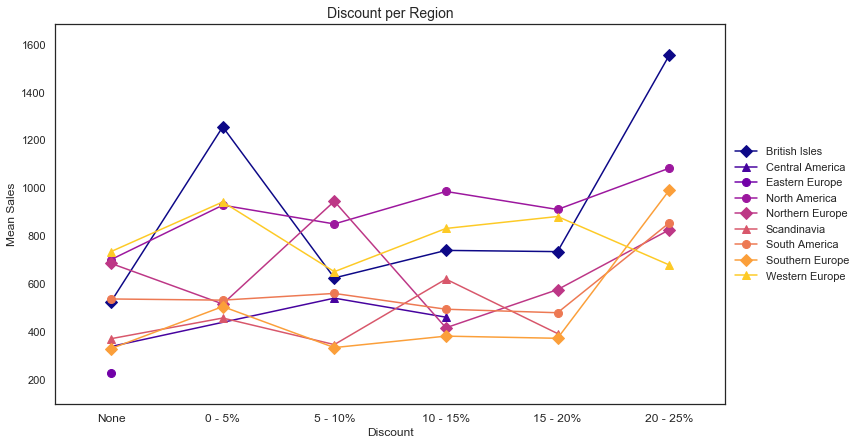

In [57]:
NUM_COLORS = 9

cm = pylab.get_cmap('plasma')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple

# or if you really want a generator:
cgen = list((cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)))

sns.set(style="white")
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

interaction_plot(product.DiscountGr, product.ShipRegion, product.SalePrice,
             colors=cgen, markers=['D','^', 'o', 'o', 'D', '^', 'o', 'D', '^'], ms=8, ax=ax)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Mean Sales', fontsize=12)
plt.xlabel('Discount')
plt.xticks(np.arange(6), ('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12)
plt.title('Discount per Region', fontsize=14);

## FINAL INTERPRETATION OF DISCOUNT x REGION

**Eastern Europe** was excluded since there were no discounted sales for this region. 

for **Western_Europe, South_America, and Northern_Europe** no significant difference was found for sales between any of the discounted groups. Except for Northern Europe, these samples were sufficiently powered for an effect of 0.2. If it is the case that the sample for Northern Europe is underpowered, the effect would nevertheless be small. Total discounts offered for these regions was 55742.01 Euros (6.39% of total sales; 14.29 of discounted sales).  

For **North America, Southern_Europe and the British_Isles** offering discounts did significantly drive sales. In particular:

- For **North America** discounts between 10 - 15% significantly increased Sales from 326.33 to 649.53 Euro - 99% (with a range from 28% - 285%). Discounts between 20 - 25% significantly increased Sales to 608.54 - 86% (range:26% - 176%). 

Sales where no discount was offered (GM = 326.33) were 26% less than for combined discount sales (GM = 456.84; range: 9% - 40%). Discounts between 10 - 15% significantly increased Sales to 649.53 - 47% more than for all other discounts, including no discount (range: 1% - 113%). However, a lower range of 1% is very close to zero and should be relied on with caution.

- For **Southern Europe** discounts between 1 - 5% significantly increased Sales from 175.17 to 401.26 Euro - 129% (with a range from 36% - 285%). Discounts between 20 - 25% significantly increased Sales to 630.78 - 260% (range:22% - 962%) -- the extreme variability for this range calls for caution.

Sales where no discount was offered (GM = 175.17) were 40% less than for combined discount sales (GM = 287.71; range: 17% - 57%).

- For **British Isles** discounts between 1 - 5% significantly increased Sales from 284.44 to 717.28 Euros - 152% increase (range: 2% - 522%). Discounts between 5 - 10% significantly increased Sales to 459.09 - 61% (range:0% - 160%). Discounts between 20 - 25% significantly increased Sales to 827.05 - 191% (range:50% - 464%). A lower range of 0% and 2% should be relied on with caution; these effects are inconsistent due to extremes (and large variations) within these categories.  

Sales where no discount was offered (GM = 284.44) were 43% less than for combineded discount sales (GM = 545.72; range: 24% - 58%).

- For **Scandinavia and Central America** there were no significant differences found in sales for any discounts (including no discount). However, it should be noted that these sample sizes were small and more data is needed for final decisions. 

Sales in three of eight regions are currently benefitting from discounts.  

# FINAL CONSIDERATIONS:

To further refine the emerging understanding of discount on sales, it is important to check two more potential interactions:

1) Whether those categories with discount effects coincide with the regions with discounted effects; or whether category and region are largely independent from each other. 

$H_0$: **There is no interaction between Product Category and Region with regard to Discount**

$H_1$: **There is an interaction between Product Category and Region with regard to Discount**


2) Whether there is any interaction with Employee - i.e., are certain employees better using discount to drive sales?

$H_0$: **There is no interaction between Employee and Discount**

$H_1$: **There is an interaction between Employee and Discount**


## Category Sales per Region



C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


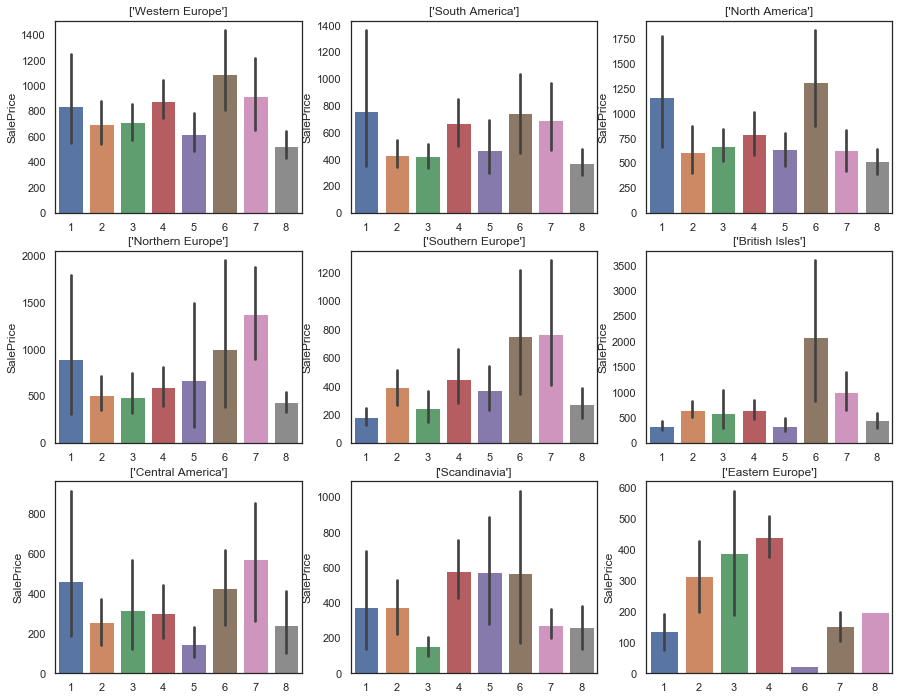

In [58]:
list_regions = [Western_Europe, South_America, North_America, Northern_Europe, 
                Southern_Europe, British_Isles, Central_America, Scandinavia, Eastern_Europe]

fig = plt.figure(figsize=(15,12))
sns.set_style("white")

for num, r in enumerate(list_regions, start=1):
    df0 = r
    ax = fig.add_subplot(3,3,num)
    ax.set_title(r.ShipRegion.unique())
    sns.barplot(x='CategoryId', y='SalePrice', data=df0, ax=ax)
    ax.set_xlabel(None)

plt.show()

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


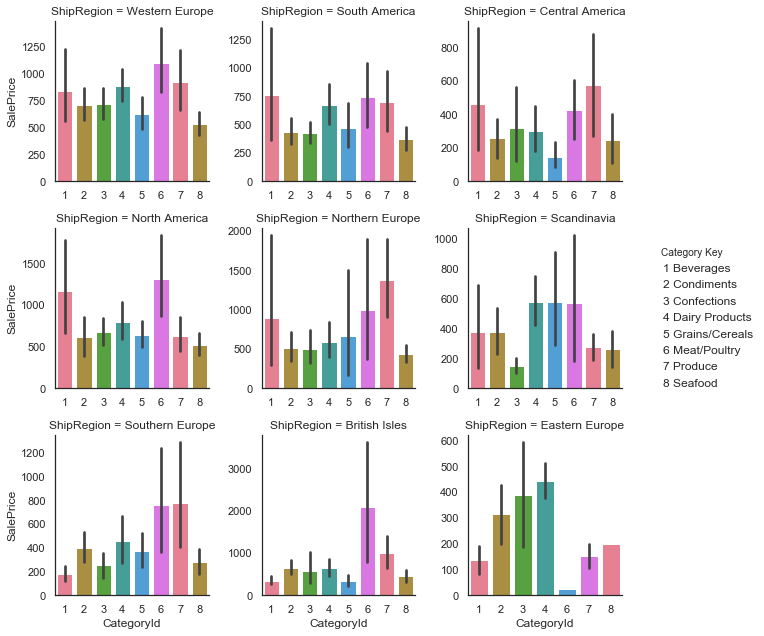

In [59]:
#fig = plt.figure(figsize=(13,11))

#plt.rcParams['figure.figsize']=(10,10)
sns.set_style("white")

g = sns.FacetGrid(product, col='ShipRegion',
            col_wrap=3,
            sharex=False,
            sharey=False,
            height=2,
            size=3,
            aspect=1)
g = g.map(sns.barplot, 'CategoryId', 'SalePrice', 
          palette=sns.color_palette("husl"))

g.add_legend(label_order=['1 Beverages', '2 Condiments',        
'3 Confections',       
'4 Dairy Products',    
'5 Grains/Cereals',    
'6 Meat/Poultry',      
'7 Produce',           
'8 Seafood'], title='Category Key', fontsize=12)


In [60]:
list_regions2 = [Western_Europe, South_America, North_America, Northern_Europe, 
                Southern_Europe, British_Isles, Central_America, Scandinavia]

levels = [i for i in range(0, len(set(product.ShipRegion)))]

# Sum contrast for discount - each group is compared to the unweighted mean of all other groups
sum_r = Sum(omit=8).code_without_intercept(levels)
sum_c = Sum()
print(sum_r.matrix)
print(sum_c)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


In [61]:
def region_category(list_df, alpha=0.05, power=0.8, effect=0.25):
    for i in list_df:
        lm = smf.ols('LogSales ~ C(DiscountBi) * C(CategoryId, sum_c)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        
        # Output
        print(i.ShipRegion.unique())
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,:5])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))
    
    # calculate required sample size for specified power and alpha values 
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect, 
                                         power = power, 
                                         alpha = alpha)
    print('Required sample size for power {} and effect size {}: {}'.format(power, effect, round(sample_size)))


region_category(list_regions2)

['Western Europe']
------------------------------------------------------------------------------
<F test: F=array([[2.35463845]]), p=0.0026285597706834645, df_denom=729, df_num=15>
R2 Adjusted:  0.025966553887086907
                         OLS        coef    std err          z   P>|z|
0                  Intercept      6.0601      0.058    104.329   0.000
1  C(CategoryId, sum_c)[S.1]     -0.3003      0.137     -2.185   0.029
2  C(CategoryId, sum_c)[S.4]      0.2921      0.115      2.536   0.011
Power for given sample size for an effect of 0.25: 0.999999411445309


['South America']
------------------------------------------------------------------------------
<F test: F=array([[1.48336796]]), p=0.10885456574557652, df_denom=339, df_num=15>
R2 Adjusted:  0.015320297446911546
         OLS        coef    std err          z   P>|z|
0  Intercept      5.8098      0.077     75.685   0.000
Power for given sample size for an effect of 0.25: 0.9969670264488436


['North America']
--------------

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  'rank is %d' % (J, J_), ValueWarning)


## INTERPRETATION

#### KEY
0 Beverages
1 Condiments      
2 Confections       
3 Dairy Products    
4 Grains/Cereals   
5 Meat/Poultry      
6 Produce           
7 Seafood


#### INTERACTIONS:

- North America x Confections
- North America x Seafood

- **North America x Seafood x Discount**


- Southern Europe x Condiments
- Southern Europe x Dairy
- Southern Europe x Grains/Cereal


- British Isles x Confections
- British Isles x Produce
- British Isles x Seafood


While there were multiple instances of interactions between the regions and categories of interest (i.e., those shown to have discount effects), there was only one instance of a region x category x discount interaction. Specifically, North American sales in Seafood were significantly increased by discount. It is uncertain how much of the previously identified main effects of discount on Seafood and main effects of discount on North America are indepedent of this interaction, but we can more certainly identify the effect of discount now with this product category for a specific region.


Equally informative is the _lack_ of interactions for any other product category and region (at least for within-region effects). Due to computational complexity and matrix mismatches I was unable to run a between-Regions analysis, so there may still be effects when regions are compared with each other. However, for now we can consider the discount effects for category and discount effects for region to be largely independent. We fail to reject the null hypothesis: $H_0$: **There is no interaction between Product Category and Region with regard to Discount**

## Employee Use of Discount

In [62]:
product['EmployeeZ'] = product.groupby('EmployeeId')['SalePrice'].apply(lambda x: (x - x.mean()) / x.std())
product['LogEmployeeZ'] = product.groupby('EmployeeId')['LogSales'].apply(lambda x: (x - x.mean()) / x.std())

In [63]:
product['SaleZ'] = (product['SalePrice'] - product['SalePrice'].mean())/ product.SalePrice.std()
product['LogSaleZ'] = (product['LogSales'] - product['LogSales'].mean())/ product.LogSales.std()

In [64]:
product.head()

,EmployeeId,ShipRegion,Quantity,Discount,UnitPrice,CategoryId,CategoryName,Revenue,SalePrice,ReportsTo,DiscountBi,DiscountGr,LogSales,EmployeeZ,LogEmployeeZ,SaleZ,LogSaleZ
0,5,Western Europe,12,0.0,14.0,4,Dairy Products,219.62,252.00,2.0,0.0,0.0,5.529429,-0.385172,-0.395054,-0.378794,-0.283687
1,5,Western Europe,10,0.0,9.8,5,Grains/Cereals,107.62,140.00,2.0,0.0,0.0,4.941642,-0.481749,-0.946083,-0.479671,-0.788259
2,5,Western Europe,5,0.0,34.8,4,Dairy Products,141.62,174.00,2.0,0.0,0.0,5.159055,-0.452431,-0.742266,-0.449048,-0.601626
3,6,Western Europe,9,0.0,18.6,7,Produce,197.64,209.25,5.0,0.0,0.0,5.343530,-0.500011,-0.321610,-0.417298,-0.443268
4,6,Western Europe,40,0.0,42.4,7,Produce,2108.39,2120.00,5.0,0.0,0.0,7.659171,2.808074,1.839614,1.303693,1.544542


In [65]:
# How are employees using discount?
levels = [i for i in range(len(set(product.EmployeeId)))]
levels1 = [i for i in range(len(set(product.DiscountGr)))]

sum_e = Sum(omit=8).code_without_intercept(levels)
sum_d = Sum(omit=0).code_without_intercept(levels1)

#print(sum_e.matrix)
#print(sum_d.matrix)

In [66]:
for i in product.EmployeeId.unique():
    locals()['E' + str(i) + '_df'] = product.loc[product['EmployeeId'] == i]
    
list_employee_df = [E1_df, E2_df, E3_df, E4_df, E5_df, E6_df, E7_df, E8_df, E9_df]

In [67]:
for df in list_employee_df:
    manager = df.ReportsTo.unique()
    emp_id = df.EmployeeId.unique()
    print('Employee {} reports to {}'.format(emp_id, manager)) 

Employee [1] reports to [2.]
Employee [2] reports to [nan]
Employee [3] reports to [2.]
Employee [4] reports to [2.]
Employee [5] reports to [2.]
Employee [6] reports to [5.]
Employee [7] reports to [5.]
Employee [8] reports to [2.]
Employee [9] reports to [5.]


In [68]:
total_discounts = 0
total_sales = 0
discounted_sales = 0
for emp in list_employee_df:
    sales = sum(emp.SalePrice)
    df = emp.loc[emp['DiscountBi'] == 1].copy()
    df['DiscountValue'] = df.SalePrice * df.Discount
    discount = sum(df.DiscountValue)
    print('Total Discount on Sales for Employee {} was {} Euros'.format(emp.EmployeeId.unique(), round(discount, 2)))
    print('Total sales were: {}'.format(round(sales,2)))
    print('{}% of total sales.\n'.format(round(discount/sales*100, 2)))
    total_discounts += discount
    discounted_sales += sum(df.SalePrice)
    total_sales += sum(emp.SalePrice)

print('\nTotal discount offered by Employees was {} Euros.'. format(round(total_discounts,2)))
print('This was {}% of discounted sales.'. format(round((total_discounts/discounted_sales)*100,2)))
print('This was {}% of all sales were discounts.'. format(round((total_discounts/total_sales)*100,2)))


Total Discount on Sales for Employee [1] was 11029.28 Euros
Total sales were: 215717.79
5.11% of total sales.

Total Discount on Sales for Employee [2] was 11519.62 Euros
Total sales were: 185395.12
6.21% of total sales.

Total Discount on Sales for Employee [3] was 10719.72 Euros
Total sales were: 225605.47
4.75% of total sales.

Total Discount on Sales for Employee [4] was 19034.96 Euros
Total sales were: 275109.98
6.92% of total sales.

Total Discount on Sales for Employee [5] was 7700.07 Euros
Total sales were: 81745.85
9.42% of total sales.

Total Discount on Sales for Employee [6] was 4610.52 Euros
Total sales were: 83673.45
5.51% of total sales.

Total Discount on Sales for Employee [7] was 18079.41 Euros
Total sales were: 151602.19
11.93% of total sales.

Total Discount on Sales for Employee [8] was 6817.6 Euros
Total sales were: 143950.86
4.74% of total sales.

Total Discount on Sales for Employee [9] was 6153.17 Euros
Total sales were: 86566.6
7.11% of total sales.


Total di

In [80]:
((11029.28 + 10719.72 + 4610.52 + 6817.6 + 6153.17)/(215717.79+225605.47+83673.45+143950.86+86566.6))*100
(11029.28 + 10719.72 + 4610.52 + 6817.6 + 6153.17)

39330.29

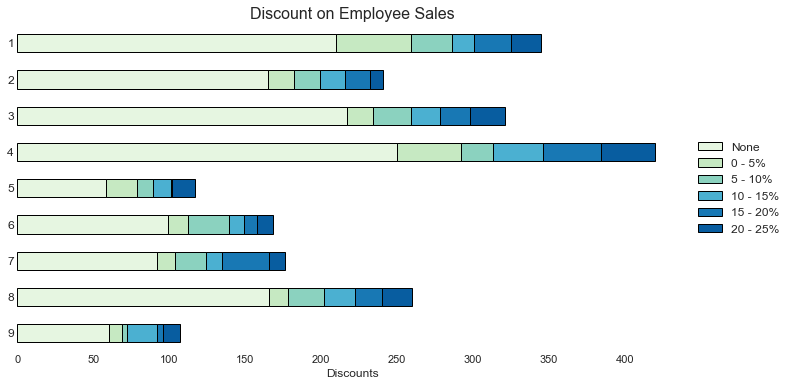

In [69]:
stacked_bar(product, 'EmployeeId', 'DiscountGr',
            legend_label=['None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'], 
            title='Discount on Employee Sales', 
            xlabel='Discounts')

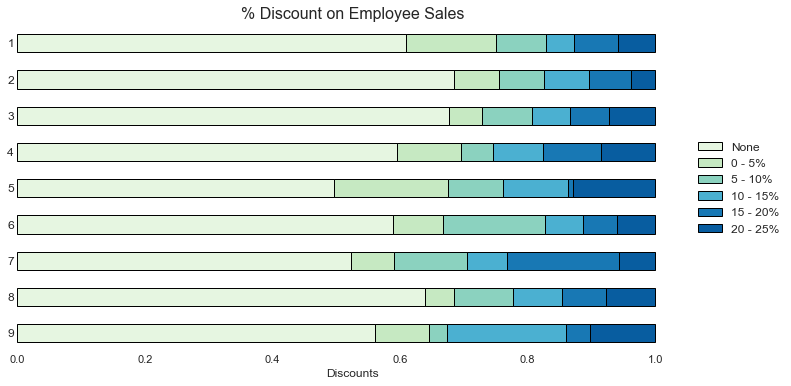

In [70]:
stacked_bar(product, 'EmployeeId', 'DiscountGr',
            legend_label=['None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'], 
            title='% Discount on Employee Sales', 
            xlabel='Discounts',
            normalize=True)

In [76]:
def employee_discount(list_df, alpha=0.05, power=0.8, effect=0.25):
    for i in list_df:
        lm = smf.ols('LogSales ~ C(DiscountGr)', data = i).fit(cov_type='HC3')
        df = pd.DataFrame(data = [x for x in lm.summary().tables[1].data[1:] if float(x[4]) < alpha], 
                          columns = lm.summary().tables[1].data[0])
        df.rename(columns={'': 'OLS'}, inplace=True)
        pd.options.display.max_colwidth = 120
        
        # this tests that each coefficient is jointly statistically significantly different from zero
        A = np.identity(len(lm.params))
        A = A[1:,:]
        
        # calculate power already in analysis
        import statsmodels.stats.power as smp
        from statsmodels.stats.power import TTestIndPower, FTestPower
        df_denom = len(i) - 1
        pred_power = smp.FTestPower().solve_power(effect_size=effect, 
                                                  df_num=df_denom, df_denom=1, alpha=alpha)
        # Output
        print('Employee: ', i.EmployeeId.unique())
        print('------------------------------------------------------------------------------')
        print(lm.f_test(A))
        print('R2 Adjusted: ', lm.rsquared_adj)
        print(df.iloc[:,:5])
        print('Power for given sample size for an effect of {}: {}\n\n'.format(effect, pred_power))
    
    # calculate required sample size for specified power and alpha values 
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect, 
                                         power = power, 
                                         alpha = alpha)
    print('Required sample size for power {} and effect size {}: {}'.format(power, effect, round(sample_size)))

employee_discount(list_employee_df)

Employee:  [1]
------------------------------------------------------------------------------
<F test: F=array([[1.07861091]]), p=0.3719364699992854, df_denom=339, df_num=5>
R2 Adjusted:  -0.0027988989012146526
                    OLS        coef    std err          z   P>|z|
0             Intercept      5.6472      0.086     65.432   0.000
1  C(DiscountGr)[T.5.0]      0.4736      0.236      2.003   0.045
Power for given sample size for an effect of 0.25: 0.9962889994000054


Employee:  [2]
------------------------------------------------------------------------------
<F test: F=array([[4.78108613]]), p=0.0003512103008719895, df_denom=235, df_num=5>
R2 Adjusted:  0.06388951670706433
                    OLS        coef    std err          z   P>|z|
0             Intercept      5.6972      0.095     59.861   0.000
1  C(DiscountGr)[T.1.0]      1.0412      0.276      3.771   0.000
2  C(DiscountGr)[T.3.0]      0.7636      0.261      2.921   0.003
3  C(DiscountGr)[T.5.0]      0.9772      0.4

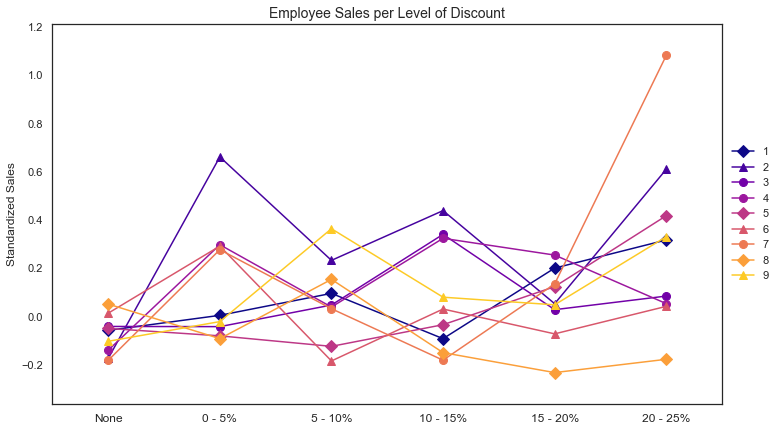

In [74]:
NUM_COLORS = 9

cm = pylab.get_cmap('plasma')
for i in range(NUM_COLORS):
    color = cm(1.*i/NUM_COLORS)  # color will now be an RGBA tuple

# or if you really want a generator:
cgen = list((cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)))

sns.set(style="white")
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

interaction_plot(product.DiscountGr, product.EmployeeId, product.LogEmployeeZ,
                 colors=cgen, markers=['D','^', 'o', 'o', 'D', '^', 'o', 'D', '^'], 
                 ms=8, ax=ax,)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Standardized Sales', fontsize=12)
plt.xlabel(None)
plt.xticks(np.arange(6), ('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12)
plt.title('Employee Sales per Level of Discount', fontsize=14);

## INTERPRETATION


#### INTERACTIONS:

- Employee 1 x (20 - 25% Discount) 

- Employee 2 x (1 - 5% Discount) 
- Employee 2 x (10 - 15% Discount)
- Employee 2 x (20 - 25% Discount) 

- Employee 4 x (1 - 5% Discount) 
- Employee 4 x (10 - 15% Discount) 
- Employee 4 x (15 - 20% Discount) 

- Employee 7 x (1 - 5% Discount) 
- Employee 7 x (20 - 25% Discount) 


The above interactions were for a within-Employee analysis (i.e., each employee was assessed on their individual sales and not according to grouped sales). While non-managerial Employees 1, 4, 7 made good use of some discounts, only Employees 4 and 7 discounted sales were significantly higher than their sales without a discount. It appears that 5/7 employees are not using discounts to drive sales, despite giving 39330.29 Euro worth of discounts (5.2% of overall sales). 

Since the majority of sales for employees were not significantly different for discount vs no discount, we fail to reject the null hypothesis: $H_0$: **There is no interaction between employee and discount**


# FINAL CONCLUSION

Despite discount overall increasing sales, on closer inspection this effect was only significant for 3 regions, 4 product categories, and 2 non-managerial employees. Two considerations emerge from these findings:
 
 - For the most part, discount is not being used strategically or effectively to increase sales. 
 
 - Therefore, most of the discounts currently offered are an unnecessary loss.  

### REFERENCES 

https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/

https://stats.stackexchange.com/questions/163518/interpreting-test-results-on-log-transformed-data

http://www.jerrydallal.com/LHSP/ci_logs.htm

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/

https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/

https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va/3530#3530

Cohen (2013). Applied Multiple Regression/Correlation Analysis for the Behavioral Sciences. 

Further investigation before final decision:
1) Is the effect of discount on Quantity or Sales Price modulated by time? In other words, does offering larger discounts earlier on result in more sales over time for any customers? 